Starting forward run...


/tmp/ipykernel_346656/305094108.py:393: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Starting forward run...
Starting forward run...


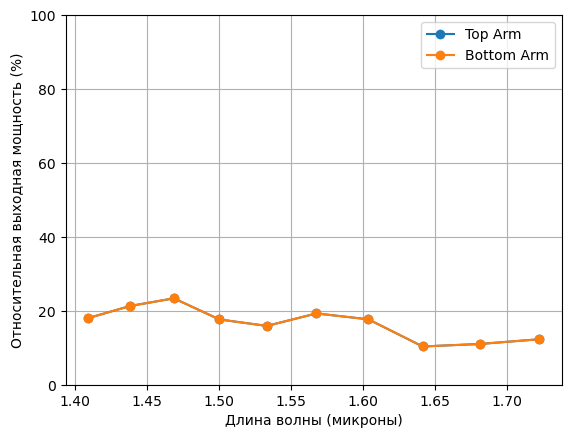

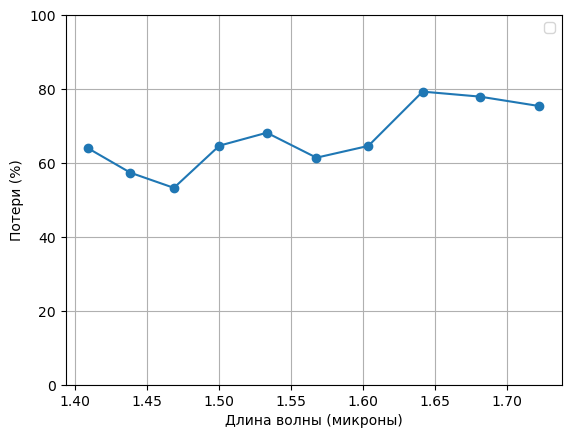

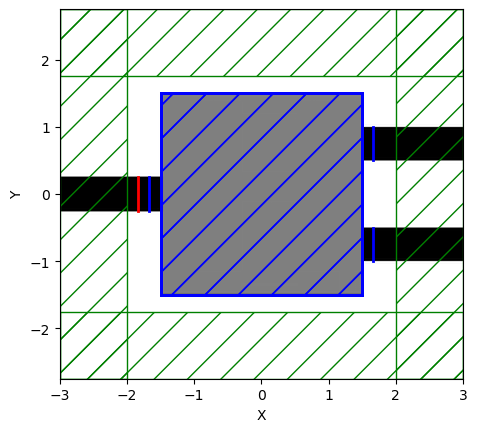

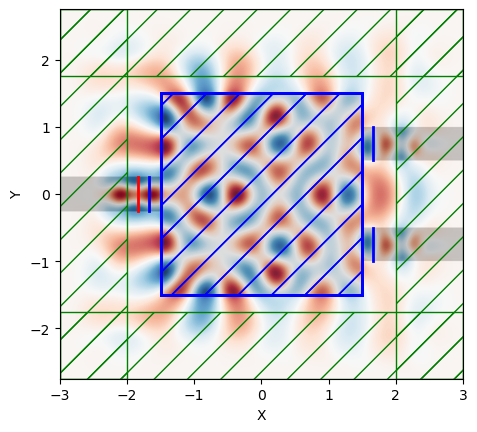

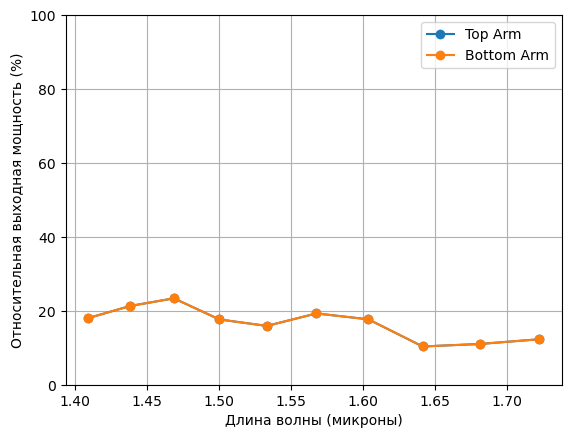

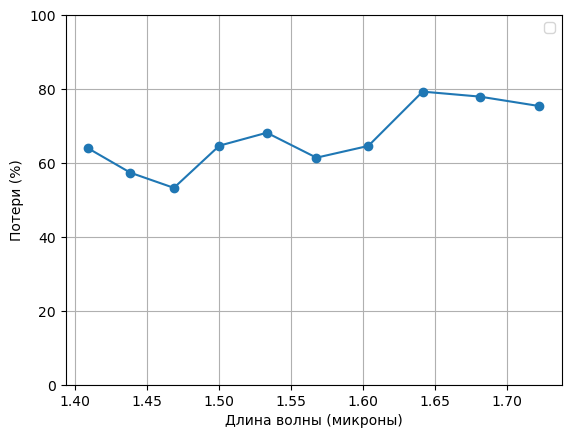

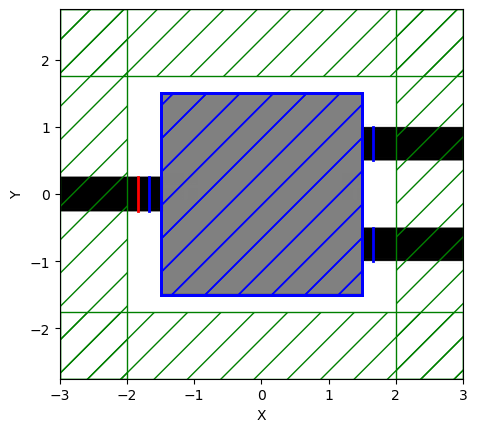

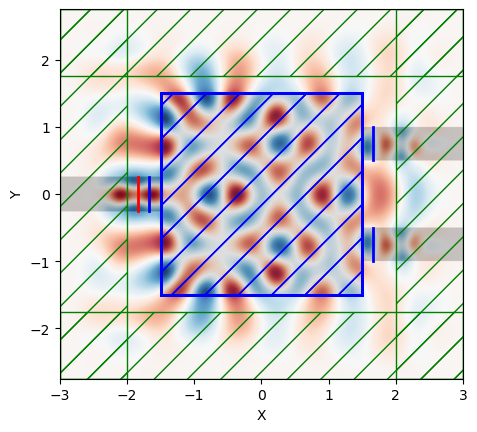

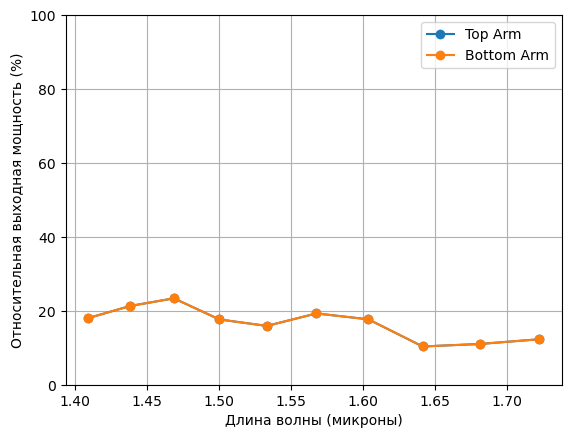

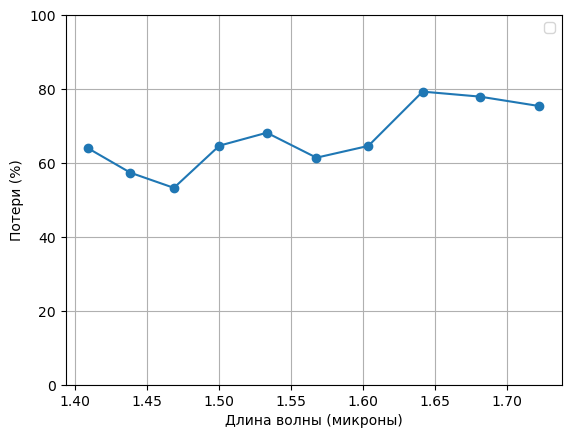

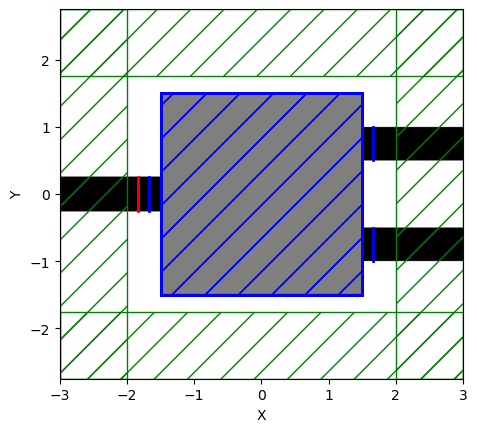

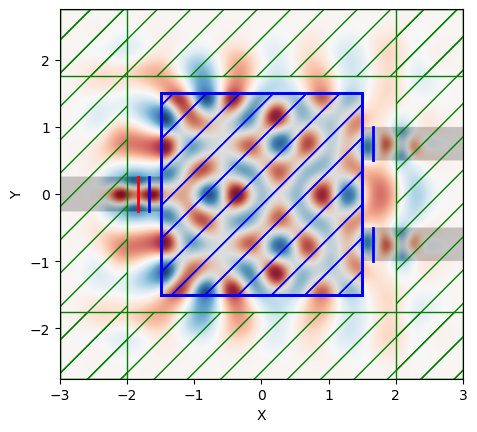

In [7]:
import meep as mp
import meep.adjoint as mpa
import autograd.numpy as npa
from autograd import tensor_jacobian_product, grad
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import nlopt
import os

seed = 240
np.random.seed(seed)
mp.quiet(quietval=True)
shapeopt=True
# Параметры
waveguide_width = 0.5
waveguide_length = 0.5
arm_separation = 1.5
wl = 1.55 #central wavelength
mode = 1
top_branch = 0.7 # % of total power on upper branch
bottom_branch = 1 - top_branch  # % of total power on lower branch

Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

folder_name = 'NOTOPT2'
file_name = 'splitter_eta_e_0.55'
os.makedirs(folder_name, exist_ok=True)

fcen = 1 / wl
width = 0.2
fwidth = width * fcen
pml_size = 1.0
resolution = 50
kpoint = mp.Vector3(1, 0, 0)
design_region_width = 3
design_region_height = 3
design_region_resolution = int(2 * resolution)
tolerance_width_and_spacing = 1e-8

min_ls = [0.05, 0.1, 0.25]
for minimum_length in min_ls:
    #minimum_length = 0.09 #minimum size of an element (used in filter)
    file_name = 'splitter_' + str(minimum_length*1000)
    eta_e = 0.55 #SIGMOID_THRESHOLD_EROSION
    filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
    eta_i = 0.5 #SIGMOID_THRESHOLD_INTRINSIC
    eta_d = 1 - eta_e #SIGMOID_THRESHOLD_DILATION

    frequencies = 1 / np.linspace(fcen - fwidth/2, fcen + fwidth/2, 10)
    Sx = 2 * pml_size + 2 * waveguide_length + design_region_width
    Sy = 2 * pml_size + design_region_height + 0.5
    cell_size = mp.Vector3(Sx, Sy)
    wg_in_center = mp.Vector3(x=-Sx / 4)
    wg_size = mp.Vector3(Sx / 2 + 1, waveguide_width, 0)
    wg_out1_center = mp.Vector3(x=Sx / 4, y=arm_separation / 2)
    wg_out2_center = mp.Vector3(x=Sx / 4, y=-arm_separation / 2)

    source_center = [-Sx/2 + pml_size + waveguide_length/3, 0, 0]
    source_size = [0,waveguide_width,0]
    monitor_in_center = [-Sx/2 + pml_size + 2*waveguide_length/3,0,0]
    monitor1_center = [Sx/2 - pml_size - 2*waveguide_length/3, arm_separation/2,0]
    monitor2_center = [Sx/2 - pml_size - 2*waveguide_length/3, -arm_separation/2, 0]
    monitor_size = source_size

    Nx = int(design_region_resolution * design_region_width) + 1
    Ny = int(design_region_resolution * design_region_height) + 1

    design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(),
            size=mp.Vector3(design_region_width, design_region_height, 0),
        ),
    )

    def line_width_and_spacing_constraint(
        result: np.ndarray,
        weights: np.ndarray,
        gradient: np.ndarray,
        sigmoid_bias: float,
    ) -> float:
        """Constraint function for the minimum line width and spacing.

        Args:
        result: evaluation of this constraint function, modified in place.
        epigraph_and_weights: 1D array containing epigraph variable (first
            element) and design weights (remaining elements).
        gradient: the Jacobian matrix, modified in place.
        sigmoid_bias: bias parameter for projection.

        Returns:
        The value of the constraint function (a scalar).
        """
        a1 = 1e-3  # hyper parameter (primary)
        b1 = 0  # hyper parameter (secondary)
        gradient[:, 0] = -a1

        filter_func = lambda a: mpa.conic_filter(
            a.reshape(Nx, Ny),
            filter_radius,
            design_region_width,
            design_region_height,
            design_region_resolution,
        )

        threshold_func = lambda a: mpa.tanh_projection(
            a, sigmoid_bias, eta_i
        )

        # hyper parameter (constant factor and exponent)
        c0 = 1e7 * (filter_radius * 1 / resolution) ** 4

        M1 = lambda a: mpa.constraint_solid(
            a, c0, eta_e, filter_func, threshold_func, 1
        )
        M2 = lambda a: mpa.constraint_void(
            a, c0, eta_d, filter_func, threshold_func, 1
        )

        g1 = grad(M1)(weights)
        g2 = grad(M2)(weights)

        result[0] = M1(weights) # - a1 * epigraph - b1
        result[1] = M2(weights) # - a1 * epigraph - b1

        gradient[0, 1:] = g1.flatten()
        gradient[1, 1:] = g2.flatten()

        t1 = (M1(weights) - b1) / a1
        t2 = (M2(weights) - b1) / a1

        print(f"line_width_and_spacing_constraint:, {result[0]}, {result[1]}, {t1}, {t2}")
        np.savetxt(f"{folder_name}/{file_name}_line_width.txt", [result[0], result[1], t1, t2])
            
        return max(t1, t2)



    pml_layers = [mp.PML(pml_size)]


    src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
    source = [
        mp.EigenModeSource(
            src,
            eig_band=mode,
            direction=mp.NO_DIRECTION,
            eig_kpoint=kpoint,
            size=source_size,
            center=source_center,
        )
    ]

    geometry = [
        mp.Block(
            center=wg_in_center,
            material=Si,
            size=wg_size,
        ),  # left waveguide
        mp.Block(
            center=wg_out1_center,
            material=Si,
            size=wg_size,
        ),  # top right waveguide
        mp.Block(
            center=wg_out2_center,
            material=Si,
            size=wg_size,
        ),  # bottom right waveguide
        mp.Block(
            center=design_region.center, size=design_region.size, material=design_variables
        ),
    ]

    sim = mp.Simulation(
        cell_size=cell_size,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=source,
        default_material=SiO2,
        resolution=resolution,
    )

    def mapping(x, eta, beta):

        # filter
        filtered_field = mpa.conic_filter(
            x,
            filter_radius,
            design_region_width,
            design_region_height,
            design_region_resolution,
        )

        # projection
        if beta != np.inf:
            projected_field = mpa.tanh_projection(filtered_field, beta, eta)
        else:
            projected_field = mpa.smoothed_projection(filtered_field, beta, eta, design_region_resolution)

        # interpolate to actual materials
        return projected_field.flatten()


    # Маска для сглаживания краев области
    # Define spatial arrays used to generate bit masks
    x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
    y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
    X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

    # Define the core mask
    left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
    top_right_wg_mask = (X_g == design_region_width / 2) & (
        np.abs(Y_g + arm_separation / 2) <= waveguide_width / 2
    )
    bottom_right_wg_mask = (X_g == design_region_width / 2) & (
        np.abs(Y_g - arm_separation / 2) <= waveguide_width / 2
    )
    Si_mask = left_wg_mask | top_right_wg_mask | bottom_right_wg_mask

    # Define the cladding mask
    border_mask = (
        (X_g == -design_region_width / 2)
        | (X_g == design_region_width / 2)
        | (Y_g == -design_region_height / 2)
        | (Y_g == design_region_height / 2)
    )
    SiO2_mask = border_mask.copy()
    SiO2_mask[Si_mask] = False

    # monitors

    TE0 = mpa.EigenmodeCoefficient(
        sim,
        mp.Volume(
            center=monitor_in_center,
            size=monitor_size,
        ),
        mode,
    )

    TE_top = mpa.EigenmodeCoefficient(
        sim,
        mp.Volume(
            center=monitor1_center,
            size=monitor_size,
        ),
        mode,
    )
    TE_bottom = mpa.EigenmodeCoefficient(
        sim,
        mp.Volume(
            center=monitor2_center,
            size=monitor_size,
        ),
        mode,
    )
    ob_list = [TE0, TE_top, TE_bottom]

    # FOM
    def J(source, top, bottom):
        top = npa.abs(top / source)**2
        bottom = npa.abs(bottom / source)**2
        power =  npa.abs(top - top_branch) + npa.abs(bottom - bottom_branch)
        return npa.mean(power)


    opt = mpa.OptimizationProblem(
        simulation=sim,
        objective_functions=J,
        objective_arguments=ob_list,
        design_regions=[design_region],
        fcen=fcen,
        df=fwidth,
        nf=10,
        decay_by=1e-5,
    )

    def f(v, gradient, cur_beta):
        print("Current iteration: {}".format(cur_iter[0] + 1))

        f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

        if gradient.size > 0:
            gradient[:] = tensor_jacobian_product(mapping, 0)(
                v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
            )

        evaluation_history.append(np.max(np.real(f0)))
        cur_iter[0] = cur_iter[0] + 1
        return np.real(f0)

    import time
    start = time.time()


    algorithm = nlopt.LD_MMA
    n = Nx * Ny  # number of parameters
    evaluation_history = []
    cur_iter = [0]
    # Initial guess
    
    '''x_m = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
    y_m = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
    X_m, Y_m = np.meshgrid(x_m, y_m, sparse=True, indexing="ij")
    mask = (np.abs(Y_g) >= (X_g*(arm_separation)/2/design_region_width+0.25*waveguide_width)) & (np.abs(Y_g) <= (X_g*(arm_separation)/2/design_region_width+1.25*waveguide_width))
    x = np.zeros((Nx, Ny))
    x[mask] = 1
    x = x.flatten()'''
    
    x = np.ones((n,)) * 0.5
    '''x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
    x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

    # lower and upper bounds
    lb = np.zeros((Nx * Ny,))
    lb[Si_mask.flatten()] = 1
    ub = np.ones((Nx * Ny,))
    ub[SiO2_mask.flatten()] = 0'''
    """
    cur_beta = 2
    beta_scale = 2
    num_betas = 6
    update_factor = 12
    for iters in range(num_betas):
        print("current beta: ", cur_beta)
        solver = nlopt.opt(algorithm, n)
        solver.set_lower_bounds(lb)
        solver.set_upper_bounds(ub)
        solver.set_min_objective(lambda a, g: f(a, g, cur_beta))
        solver.set_maxeval(update_factor)
        x[:] = solver.optimize(x)
        cur_beta = cur_beta * beta_scale
    
    tolerance_width_and_spacing = np.array([1e-8] * 2) 
    line_width_and_spacing = np.zeros(2)
    grad_line_width_and_spacing = np.zeros((2, n+1))
    linewidth_constraint_val = line_width_and_spacing_constraint(
        tolerance_width_and_spacing,
        x,
        grad_line_width_and_spacing,
        128,
    )
    solver.add_inequality_mconstraint(
        lambda result_, epigraph_and_weights_, grad_: line_width_and_spacing_constraint(
            result_,
            epigraph_and_weights_,
            grad_,
            128,
        ),
        tolerance_width_and_spacing,
    )
    """
    #runtime = time.time() - start
    #np.savetxt(f"{folder_name}/{file_name}_runtime.txt", [runtime])
    #np.savetxt(f"{folder_name}/{file_name}_maziter.txt", [cur_iter[0]])
    #np.save(f"{folder_name}/{file_name}_optimal_design.npy", x)
    
    """plt.figure()
    plt.plot(np.array(evaluation_history), "o-")
    plt.grid(True)
    plt.xlabel("Итерация")
    plt.ylabel("Целевая функция")
    plt.ylim(0,100)
    np.save(f"{folder_name}/{file_name}_history.npy", np.array(evaluation_history))
    plt.savefig(f"{folder_name}/{file_name}_history.png")"""

    
    f0, dJ_du = opt([mapping(x, eta_i, 128)], need_gradient=False)
    frequencies = opt.frequencies
    source_coef, top_coef, bottom_ceof = opt.get_objective_arguments()

    top_profile = np.abs(top_coef / source_coef) ** 2
    bottom_profile = np.abs(bottom_ceof / source_coef) ** 2
    np.savetxt(f"{folder_name}/{file_name}_top.txt", top_profile)
    np.savetxt(f"{folder_name}/{file_name}_bottom.txt", bottom_profile)
    np.savetxt(f"{folder_name}/{file_name}_means.txt", [np.mean(top_profile), np.mean(bottom_profile), np.mean(top_profile + bottom_profile)])
    plt.figure()
    plt.plot(1 / frequencies, top_profile * 100, "-o", label="Top Arm")
    plt.plot(1 / frequencies, bottom_profile * 100, "-o", label="Bottom Arm")
    plt.ylim(0,100)
    plt.legend()
    plt.grid(True)
    plt.xlabel("Длина волны (микроны)")
    plt.ylabel("Относительная выходная мощность (%)")
    plt.savefig(f"{folder_name}/{file_name}_power_by_arm.png")
    plt.figure()
    plt.plot(1 / frequencies, 100 - (top_profile + bottom_profile) * 100, "-o")
    plt.ylim(0,100)
    plt.legend()
    plt.grid(True)
    plt.xlabel("Длина волны (микроны)")
    plt.ylabel("Потери (%)")
    plt.ylim(0,100)
    plt.savefig(f"{folder_name}/{file_name}_loss.png")
    plt.figure()
    sim.plot2D()
    plt.savefig(f"{folder_name}/{file_name}_geometry.png")
    plt.figure()
    sim.plot2D(fields=mp.Ez)
    plt.savefig(f"{folder_name}/{file_name}_Ez.png")

In [ ]:
conda update -c conda-forge pymeep

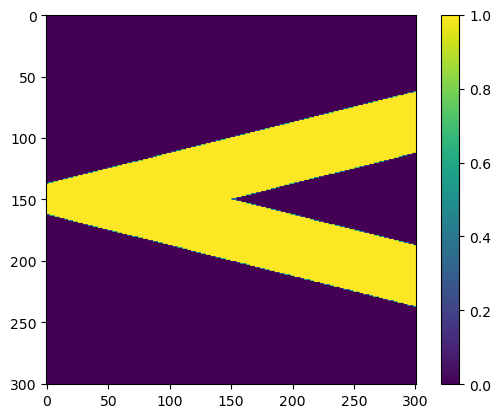

In [60]:
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")
mask = (np.abs(Y_g) <= (X_g*arm_separation/2/design_region_width + waveguide_width)) & (np.abs(Y_g) >= (X_g*arm_separation/2/design_region_width ))
x0 = np.zeros((Nx, Ny))
x0[mask.T] = 1
plt.imshow(x0)
plt.colorbar()

In [31]:
(X_g*arm_separation/2/design_region_width - waveguide_width/2)

array([[-0.625 ],
       [-0.6225],
       [-0.62  ],
       [-0.6175],
       [-0.615 ],
       [-0.6125],
       [-0.61  ],
       [-0.6075],
       [-0.605 ],
       [-0.6025],
       [-0.6   ],
       [-0.5975],
       [-0.595 ],
       [-0.5925],
       [-0.59  ],
       [-0.5875],
       [-0.585 ],
       [-0.5825],
       [-0.58  ],
       [-0.5775],
       [-0.575 ],
       [-0.5725],
       [-0.57  ],
       [-0.5675],
       [-0.565 ],
       [-0.5625],
       [-0.56  ],
       [-0.5575],
       [-0.555 ],
       [-0.5525],
       [-0.55  ],
       [-0.5475],
       [-0.545 ],
       [-0.5425],
       [-0.54  ],
       [-0.5375],
       [-0.535 ],
       [-0.5325],
       [-0.53  ],
       [-0.5275],
       [-0.525 ],
       [-0.5225],
       [-0.52  ],
       [-0.5175],
       [-0.515 ],
       [-0.5125],
       [-0.51  ],
       [-0.5075],
       [-0.505 ],
       [-0.5025],
       [-0.5   ],
       [-0.4975],
       [-0.495 ],
       [-0.4925],
       [-0.49  ],
       [-0